# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [43]:
!git clone https://github.com/sim0nsays/dlcourse_ai.git

fatal: destination path 'dlcourse_ai' already exists and is not an empty directory.


In [ ]:
!/content/dlcourse_ai/assignments/assignment1/download_data.sh

mkdir: cannot create directory ‘data’: File exists
--2022-05-22 09:00:15--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2022-05-22 09:00:15--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
!pip install -r /content/dlcourse_ai/assignments/assignment1/requirements.txt

In [ ]:
!cp /content/dlcourse_ai/assignments/assignment1/* .

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [45]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [56]:
def check_gradient(f, x, delta=1e-5, tol = 1e-4):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula
    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient
    Return:
      bool indicating whether gradients match or not
    '''
    
    assert isinstance(x, np.ndarray)
    assert x.dtype == float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric
    # derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        numeric_grad_at_ix = 0

        # TODO compute value of numeric gradient of f to idx
        x0 = x.copy()
        x1 = x.copy()
        x0[ix]+=delta
        x1[ix]-=delta
        numeric_grad_at_ix=(f(x0)[0]-f(x1)[0])/(2*delta)
        
        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False

        it.iternext()

    print("Gradient check passed!")
    return True

In [57]:
# TODO: Implement check_gradient function in gradient_check.py
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [48]:
import numpy as np

def _softmax1(z):
      # z -= np.max(z)
      return np.exp(z - np.max(z)) / (np.sum(np.exp(z - np.max(z))))


class linear_classifer:
  def softmax(predictions):
      '''
      Computes probabilities from scores
      Arguments:
        predictions, np array, shape is either (N) or (batch_size, N) -
          classifier output
      Returns:
        probs, np array of the same shape as predictions - 
          probability for every class, 0..1
      '''
      if len(predictions.shape) == 1:
          return _softmax1(predictions)
      else:
          return np.apply_along_axis(_softmax1, 1, predictions)

  def cross_entropy_loss(probs, target_index):
    '''
    Computes cross-entropy loss
    Arguments:
      probs, np array, shape is either (N) or (batch_size, N) -
        probabilities for every class
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss: single value
    '''
    y_true = np.zeros(probs.shape)
    if isinstance(target_index, int):
        y_true[target_index] = 1
    else:
        count = 0
        for sample_y_true in target_index:
            y_true[count][sample_y_true] = 1
            count += 1

    return - np.sum(y_true * np.log(probs))


  def softmax_with_cross_entropy(predictions, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient
    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)
    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    '''
    y_true = np.zeros(predictions.shape)
    if isinstance(target_index, int):
        y_true[target_index] = 1
    else:
        count = 0
        for sample_y_true in target_index:
            y_true[count][sample_y_true] = 1
            count += 1

    softmax_prob = linear_classifer.softmax(predictions)
    loss = linear_classifer.cross_entropy_loss(softmax_prob, target_index)

    dprediction = softmax_prob - y_true

    return loss, dprediction


  def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient
    Arguments:
      W, np array - weights
      reg_strength - float value
    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    '''

    # TODO: implement l2 regularization and gradient
    f = lambda x: reg_strength * np.sum(np.square(x))

    loss = f(W)

    it = np.nditer(W, flags=['multi_index'], op_flags=['readwrite'])

    grad = W.copy()
    while not it.finished:
        ix = it.multi_index

        bigger_x = W.copy()
        bigger_x[ix] += reg_strength
        lesser_x = W.copy()
        lesser_x[ix] -= reg_strength

        numeric_grad_at_ix = (f(bigger_x) - f(lesser_x)) / (2 * reg_strength)
        grad[ix] = numeric_grad_at_ix
        it.iternext()

    return loss, grad
    


  def linear_softmax(X, W, target_index):
    '''
    Performs linear classification and returns loss and gradient over W
    Arguments:
      X, np array, shape (num_batch, num_features) - batch of images
      W, np array, shape (num_features, classes) - weights
      target_index, np array, shape (num_batch) - index of target classes
    Returns:
      loss, single value - cross-entropy loss
      gradient, np.array same shape as W - gradient of weight by loss
    '''
    predictions = np.dot(X, W)

    # TODO implement prediction and gradient over W

    loss, dW = linear_classifer.softmax_with_cross_entropy(predictions, target_index)

    dW = X.transpose().dot(dW)

    return loss, dW


In [49]:
# TODO Implement softmax and cross-entropy for single sample
probs = linear_classifer.softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = linear_classifer.softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [58]:
probs = linear_classifer.softmax(np.array([-5, 0, 5]))
linear_classifer.cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [59]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = linear_classifer.softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [60]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(int)
check_gradient(lambda x: linear_classifer.softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = linear_classifer.softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [62]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(float)
target_index = np.ones(batch_size, dtype=int)

loss, dW = linear_classifer.linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_classifer.linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [63]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
linear_classifer.l2_regularization(W, 0.01)
check_gradient(lambda w: linear_classifer.l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [73]:
class LinearSoftmaxClassifier():
    def __init__(self):
        self.W = None

    def fit(self, X, y, batch_size=100, learning_rate=1e-7, reg=1e-5,
            epochs=1):
        '''
        Trains linear classifier
        
        Arguments:
          X, np array (num_samples, num_features) - training data
          y, np array of int (num_samples) - labels
          batch_size, int - batch size to use
          learning_rate, float - learning rate for gradient descent
          reg, float - L2 regularization strength
          epochs, int - number of epochs
        '''

        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y)+1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        loss_history = []
        for epoch in range(epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(batch_size, num_train, batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)
            # TODO implement generating batches from indices
            # Compute loss and gradients
            # Apply gradient to weights using learning rate
            # Don't forget to add both cross-entropy loss
            # and regularization!
            loss_epoch = np.array([])
            for batch in batches_indices:
                loss, dW = linear_classifer.linear_softmax(X[batch], self.W, y[batch])
                loss_reg, dW_reg = linear_classifer.l2_regularization(self.W, reg)
                self.W += - learning_rate * (dW + dW_reg)
                loss_epoch = np.append(loss_epoch, loss)
            loss_history.append(loss_epoch.mean())
            # end
            print("Epoch %i, loss: %f" % (epoch, loss))

        return loss_history


    def predict(self, X):
        '''
        Produces classifier predictions on the set
       
        Arguments:
          X, np array (test_samples, num_features)
        Returns:
          y_pred, np.array of int (test_samples)
        '''
        y_pred = np.zeros(X.shape[0], dtype=int)

        # TODO Implement class prediction
        # Your final implementation shouldn't have any loops
        predictions = np.dot(X, self.W)
        probs = linear_classifer.softmax(predictions)
        y_pred = probs.argmax(axis=1)

        return y_pred

In [65]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-3, batch_size=300, reg=1e1)

Epoch 0, loss: 898.952293
Epoch 1, loss: 816.194774
Epoch 2, loss: 891.429815
Epoch 3, loss: 814.898675
Epoch 4, loss: 929.844823
Epoch 5, loss: 865.632208
Epoch 6, loss: 931.091506
Epoch 7, loss: 1013.350902
Epoch 8, loss: 914.784839
Epoch 9, loss: 813.284659


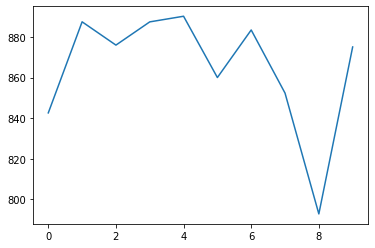

In [67]:
# let's look at the loss history!
plt.plot(loss_history)

In [71]:
def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification
    Arguments:
    prediction, np array of int (num_samples) - model predictions
    ground_truth, np array of int (num_samples) - true labels
    Returns:
    accuracy - ratio of accurate predictions to total samples
    '''
    # TODO: Implement computing accuracy
    return np.sum(prediction == ground_truth)/prediction.size

In [76]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=4, learning_rate=1e-3, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 10 epochs: ", accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy:  0.171
Epoch 0, loss: 780.251816
Epoch 1, loss: 808.829112
Epoch 2, loss: 896.284657
Epoch 3, loss: 856.075041
Accuracy after training for 10 epochs:  0.182


### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [81]:
num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = 0

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially

for rate in learning_rates:
    for reg in reg_strengths:
        loss_history = classifier.fit(train_X, train_y, epochs=4, learning_rate=rate, batch_size=300, reg=reg)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_classifier = classifier
            best_loss_history = loss_history
        print("Accuracy after training for 4 epochs: ", accuracy)
        

print('best validation accuracy achieved: %f' % best_val_accuracy)

Epoch 0, loss: 919.567136
Epoch 1, loss: 873.190574
Epoch 2, loss: 759.436764
Epoch 3, loss: 958.320935
Accuracy after training for 4 epochs:  0.198


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Epoch 0, loss: 908.075344
Epoch 1, loss: 688.420498
Epoch 2, loss: 857.344306
Epoch 3, loss: 879.891642
Accuracy after training for 4 epochs:  0.191
Epoch 0, loss: 948.545616
Epoch 1, loss: 738.038660
Epoch 2, loss: 794.650625
Epoch 3, loss: 765.950610
Accuracy after training for 4 epochs:  0.203
Epoch 0, loss: 625.796434
Epoch 1, loss: 626.515663
Epoch 2, loss: 623.843614
Epoch 3, loss: 636.415719
Accuracy after training for 4 epochs:  0.247
Epoch 0, loss: 623.707181
Epoch 1, loss: 623.445740
Epoch 2, loss: 635.799461
Epoch 3, loss: 621.762530
Accuracy after training for 4 epochs:  0.249
Epoch 0, loss: 610.967941
Epoch 1, loss: 613.006937
Epoch 2, loss: 634.112650
Epoch 3, loss: 634.807642
Accuracy after training for 4 epochs:  0.258
Epoch 0, loss: 607.698393
Epoch 1, loss: 617.969152
Epoch 2, loss: 590.952345
Epoch 3, loss: 616.196084
Accuracy after training for 4 epochs:  0.253
Epoch 0, loss: 610.863677
Epoch 1, loss: 598.154611
Epoch 2, loss: 620.473753
Epoch 3, loss: 615.927035
Ac

# Какой же точности мы добились на тестовых данных?

In [82]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.206000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
